In [1]:
'''
In this file, we calculate the von neumann entropy of a series of diagrams. 

We compare them to each other in the hope of finding that more ambiguous (less disambiguated sentences) have higher entropy. 

'''



'\nIn this file, we calculate the von neumann entropy of a series of diagrams. \n\nWe compare them to each other in the hope of finding that more ambiguous (less disambiguated sentences) have higher entropy. \n\n'

In [2]:
'''
start by importing all sorts of stuff
'''


import numpy as np
from sympy import Symbol, symbols

from lambeq.ansatz import BaseAnsatz
from lambeq.backend.grammar import Box, Diagram, Functor, Ty
from lambeq.backend.quantum import (
    Bra,
    CRz,
    Diagram as Circuit,
    Discard,
    H,
    CX,
    Id,
    Ket,
    quantum,
    qubit,
    Rotation,
    Rx, Ry, Rz
)

from lambeq import AtomicType


/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [3]:
'''
Note that for this program, we do not have to import test data. 
We test the entropy for sentences crafted in the program especially for the program. 

We write three functions for three types of sentences: 
1. The normal way of parsing 
2. Alice runs and Bob does too 
3. Alice cooks food and eats it. 
'''

from lambeq import BobcatParser
parser = BobcatParser(verbose='text')
from lambeq import RemoveCupsRewriter
remove_cups = RemoveCupsRewriter()
from lambeq import AtomicType, IQPAnsatz
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq import AtomicType
N = AtomicType.NOUN
S = AtomicType.SENTENCE
n, s = Ty('n'), Ty('s')

# create three functions for three types of diagrams

def GijsDiag(sentence:str): 
    '''
    This function, given a sentence of the form: 
    Subj Verb Obj and Subj* does too
    , returns a diagram that copies the information in such a way that the returned diagram reads: 
    Subj Verb Obj and Subj* Verb Obj
    The object will be removed later to work with density matrices. 
    '''
    wordList = sentence.split()
    grammar = (Spider(n, 2, 1) @ Id(n.r) @ Id(s) @ Cup(n.l, n) >> 
            Cup(n, n.r) @ Id(s) )
    newWords = [
        Word(wordList[0], n),
        Word(wordList[4], n),
        Word(wordList[1], n.r @ s @ n.l), 
        Word(wordList[2], n)
    ]

    diagram = Id().tensor(*newWords) >> grammar
    diagram = remove_cups(diagram)
    diagram.draw()

    circuit = ansatz(diagram= diagram)

    return circuit#, diagram 

def NaiveDiag(sentence:str):
    '''
    Simply returns a naive circuit given a diagram
    '''
    diagram = parser.sentence2diagram(sentence= sentence, suppress_exceptions=True)

    diagram = remove_cups(diagram)

    circuit = ansatz(diagram= diagram)

    return circuit#, diagram

def AmbiguousVerb(sentence:str):
    '''
    This function, given a sentence like: 
    Subj Verb Obj and Verb* it. (Man prepares dinner and eats it.) 
    returns a diagram that copies the information, so that: 
    Subj Verb Obj and Subj Verb* Obj
    The object will be removed later 
    '''
    wordList = sentence.split()
    grammar = (Spider(n, 1, 2) @ Id(n.r) @ Id(s) @ Id(n.l) @ Spider(n, 1, 2)  >> 
                Id(n) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Id(n) >> 
                Id(n) @ Word(wordList[4], n.r @ s @ n.l) @ Id(s) @ Id(n) >> 
                Cup(n, n.r) @ Id(s) @ Swap(n.l, s) @ Id(n) >> 
                Spider(s, 2, 1) @ Cup(n.l, n))
    newWords = [
        Word(wordList[0], n),
        Word(wordList[1], n.r @ s @ n.l),
        Word(wordList[2], n)
    ]


    diagram = Id().tensor(*newWords) >> grammar
    diagram = remove_cups(diagram)
    circuit = ansatz(diagram= diagram)

    return circuit#, diagram




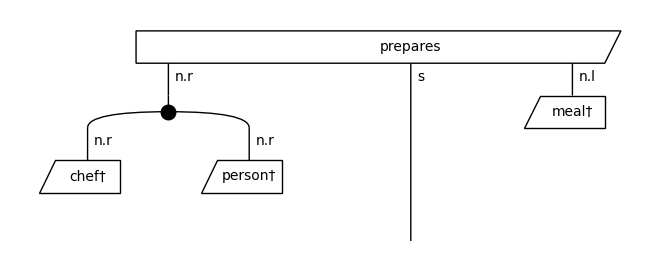

In [4]:
naiveSentences = ['person prepares meal']

gijsSentences = ['person prepares meal and chef does too']

mySentences = ['person prepares meal and cooks it']

naiveCircuits = []
gijsCircuits  = []
myCircuits    = []


for nS in naiveSentences: 
    naiveCircuits.append(NaiveDiag(nS))

for gS in gijsSentences: 
    gijsCircuits.append(GijsDiag(gS))

for mS in mySentences: 
    myCircuits.append(AmbiguousVerb(mS))


In [5]:
'''
import the functions needed to set up the diagrams using the trained weights 
'''

from entropyHelpers import *


In [6]:
'''
import trained weights 
'''
# one of these two is wordsToForget
wordsToForgetSubj = ['man', 'woman', 'person']
wordsToForgetObj  = ['dinner', 'meal', 'sauce', 'program', 'application', 'software']

# load dictionary with pickle
import pickle 

# Numpymodel 
with open('../datasets/weightsDictNPGijs.pkl', 'rb') as fp: 
    parameterDictNP = pickle.load(fp)

# Numpymodel 
with open('../datasets/weightsDictTKGijs.pkl', 'rb') as fp: 
    parameterDictTK = pickle.load(fp)

# Pennylane model 
with open('../datasets/weightsDictPLGijs.pkl', 'rb') as fp: 
    parameterDictPL = pickle.load(fp)


In [7]:
'''
apply the functions
'''

parameterDict = parameterDictNP
parameterDict = parameterDictTK
parameterDict = parameterDictPL

naiveDMList = []
gijsDMList = []
myDMList = []

for nC in naiveCircuits: 
    naiveDMList.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj)[0])

for gC in gijsCircuits: 
    gijsDMList.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj)[0])

for mC in myCircuits:
    myDMList.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj)[0])


iteration number:  0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


meal†_n__0
meal†_n__1
meal†_n__2
person†_n__0
person†_n__1
person†_n__2
prepares__n.r@s@n.l_0
prepares__n.r@s@n.l_1


/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


iteration number:  0
meal†_n__0
meal†_n__1
meal†_n__2
person†_n__0
person†_n__1
person†_n__2
prepares__n.r@s@n.l_0
prepares__n.r@s@n.l_1
iteration number:  0
meal†_n__0
meal†_n__1
meal†_n__2
person†_n__0
person†_n__1
person†_n__2
prepares__n.r@s@n.l_0
prepares__n.r@s@n.l_1


In [ ]:
print(myDMList)